# Final Project

# Comparing Neural Networks for NHL Performance Forecasting

**Group ID: 44**

**Members:<br>
Trevor Lee - 100751771**

The goal here is to use the NHL Player Statistics dataset from Kaggle to compare two different models and see which is more accurate for predicting future performance in the NHL. The dataset contains stats from roughly 1979-1980 to 2019-2020. The selected models will be used to project performance for select players of different ages and positions to project their performance in the 2020-2021 season and then the predictions will be compared to the actual results to see which were more accurate. Only select players will be used because the 2020-2021 season stats are not included in the dataset and I will have to compare them manually. The goal will be to assess and compare the viability of the chosen models to predict player performance based off of their prior three seasons played.

We will be using the NHL Player Statistics dataset by Benzik on Kaggle (https://www.kaggle.com/datasets/alexbenzik/nhl-players-statistics)

## Preparing the Data

The first thing we need to do is prepare the data so that it is suitable for training.

In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

import torchinfo

import shutil, os, time
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch import Trainer, seed_everything
from lightning.pytorch import LightningModule

import matplotlib.pyplot as plt


Load the data set as a dataframe. The values are serparated by semi-colons instead of commas, so I need to redefine the serparator.

In [2]:
df = pd.read_csv('NHL_Players_Statistics.csv', sep=';')

df.head()

,Name,Date_of_birth,SEASON_year,SEASON,TEAM,Games_Played,Goals,Assists,Points,PlusMinus_Ratings,...,Saves,Save_Percentage,Shutouts,Position,Height,Weight,Body_mass_index,Place_of_birth,Age,Experience
0,Aaron Downey,1974-08-27,2000,'99-'00,BOS,1,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,Right_wing,185,98,28.6,"Shelburne, Ontario",26,1
1,Aaron Downey,1974-08-27,2001,'00-'01,CHI,3,0.0,0.0,0.0,-1.0,...,NaN,NaN,NaN,Right_wing,185,98,28.6,"Shelburne, Ontario",27,2
2,Aaron Downey,1974-08-27,2002,'01-'02,CHI,36,1.0,0.0,1.0,-2.0,...,NaN,NaN,NaN,Right_wing,185,98,28.6,"Shelburne, Ontario",28,3
3,Aaron Downey,1974-08-27,2003,'02-'03,DAL,43,1.0,1.0,2.0,1.0,...,NaN,NaN,NaN,Right_wing,185,98,28.6,"Shelburne, Ontario",29,4
4,Aaron Downey,1974-08-27,2004,'03-'04,DAL,37,1.0,1.0,2.0,2.0,...,NaN,NaN,NaN,Right_wing,185,98,28.6,"Shelburne, Ontario",30,5


Now let's take a look at properties of the dataset.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27319 entries, 0 to 27318
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Name                   27319 non-null  object 
 1   Date_of_birth          27319 non-null  object 
 2   SEASON_year            27319 non-null  int64  
 3   SEASON                 27319 non-null  object 
 4   TEAM                   27319 non-null  object 
 5   Games_Played           27319 non-null  int64  
 6   Goals                  24802 non-null  float64
 7   Assists                24802 non-null  float64
 8   Points                 24802 non-null  float64
 9   PlusMinus_Ratings      24802 non-null  float64
 10  Penalty_Minutes        24802 non-null  float64
 11  Shots_on_Goal          24802 non-null  float64
 12  Shooting_Percentage    24802 non-null  float64
 13  PowerPlay_Goals        24802 non-null  float64
 14  PowerPlay_Assists      24802 non-null  float64
 15  Sh

The first thing we need to trim from the dataset is players with the position of `'Goaltender'`. These players have their stats recorded differently than skaters do and can cause issues.

In [4]:
df = df[df['Position'] != 'Goaltender'].copy()

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24802 entries, 0 to 27318
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Name                   24802 non-null  object 
 1   Date_of_birth          24802 non-null  object 
 2   SEASON_year            24802 non-null  int64  
 3   SEASON                 24802 non-null  object 
 4   TEAM                   24802 non-null  object 
 5   Games_Played           24802 non-null  int64  
 6   Goals                  24802 non-null  float64
 7   Assists                24802 non-null  float64
 8   Points                 24802 non-null  float64
 9   PlusMinus_Ratings      24802 non-null  float64
 10  Penalty_Minutes        24802 non-null  float64
 11  Shots_on_Goal          24802 non-null  float64
 12  Shooting_Percentage    24802 non-null  float64
 13  PowerPlay_Goals        24802 non-null  float64
 14  PowerPlay_Assists      24802 non-null  float64
 15  Short_G

The reduced number of entries and the goalie stats all having a count of 0 confirms that the correct players were removed.

Next we want to only keep the relevant columns or ones that could be relevant rather than keep all 40 columns.

In [5]:
cols = [
    'Name',
    'Date_of_birth',    # needed to differentiate players with the same name playing in the same year
    'SEASON_year',
    'Games_Played',
    'Goals',
    'Assists',
    'Points',
    'Shots_on_Goal',
    'Shooting_Percentage',
    'PowerPlay_Goals',
    'PowerPlay_Assists',
    'Short_Goals',
    'Short_Assists',
    'Position',
    'Height',
    'Weight',
    'Body_mass_index',
    'Age',
    'Experience',
]

df = df[cols].copy()

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24802 entries, 0 to 27318
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Name                 24802 non-null  object 
 1   Date_of_birth        24802 non-null  object 
 2   SEASON_year          24802 non-null  int64  
 3   Games_Played         24802 non-null  int64  
 4   Goals                24802 non-null  float64
 5   Assists              24802 non-null  float64
 6   Points               24802 non-null  float64
 7   Shots_on_Goal        24802 non-null  float64
 8   Shooting_Percentage  24802 non-null  float64
 9   PowerPlay_Goals      24802 non-null  float64
 10  PowerPlay_Assists    24802 non-null  float64
 11  Short_Goals          24802 non-null  float64
 12  Short_Assists        24802 non-null  float64
 13  Position             24802 non-null  object 
 14  Height               24802 non-null  int64  
 15  Weight               24802 non-null  int6

In [6]:
df.head()

,Name,Date_of_birth,SEASON_year,Games_Played,Goals,Assists,Points,Shots_on_Goal,Shooting_Percentage,PowerPlay_Goals,PowerPlay_Assists,Short_Goals,Short_Assists,Position,Height,Weight,Body_mass_index,Age,Experience
0,Aaron Downey,1974-08-27,2000,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Right_wing,185,98,28.6,26,1
1,Aaron Downey,1974-08-27,2001,3,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,Right_wing,185,98,28.6,27,2
2,Aaron Downey,1974-08-27,2002,36,1.0,0.0,1.0,10.0,10.0,0.0,0.0,0.0,0.0,Right_wing,185,98,28.6,28,3
3,Aaron Downey,1974-08-27,2003,43,1.0,1.0,2.0,14.0,7.1,0.0,0.0,0.0,0.0,Right_wing,185,98,28.6,29,4
4,Aaron Downey,1974-08-27,2004,37,1.0,1.0,2.0,11.0,9.1,0.0,0.0,0.0,0.0,Right_wing,185,98,28.6,30,5


Here's an issue I noticed with the `'Position'` data:

In [7]:
df["Position"].unique()

array(['Right_wing', 'Centre', 'Defence', 'Left_wing', 'Forward'],
      dtype=object)

Most of the categorization is fine. However, having `'Forward'` as a category is a bit of an issue. We don't know which of the forward positions to apply to the player. While it might only affect a few players, it does complicate the data. As such, we'll map forward to 0 and defence to 1.

In [8]:
df['Position'] = np.where(
    df['Position'].str.contains('Defen', case=False, na=False),
    1,  # Defence
    0,  # Forward
)

Next we need to handle instances where the player swaps teams for whatever reason (i.e. trade, waivers) within a given season. This will be done by aggregating their stats.

In [9]:
# These are the columns used to identify a player
id_cols = [
    'Name',
    'Date_of_birth',
    'SEASON_year',
]

# These are the stats to be summed within a season if there are multiple entries
# for a player
sum_cols = [
    'Games_Played',
    'Goals',
    'Assists',
    'Points',
    'Shots_on_Goal',
    'PowerPlay_Goals',
    'PowerPlay_Assists',
    'Short_Goals',
    'Short_Assists',
]

# These are the other columns with data we want to keep and should theoretically
# be the same within the given season
other_cols =[
    'Position',
    'Height',
    'Weight',
    'Body_mass_index',
    'Age',
    'Experience',
]

# Here we define how the data will be aggregated
agg_dict = {col: 'sum' for col in sum_cols}
agg_dict.update({col: 'first' for col in other_cols})

df = df.groupby(id_cols, as_index=False).agg(agg_dict)

# We also need to recompute shooting percentage
# This will also be marginally more accurate since the dataset only has one
# decimal point
df['Shooting_Percentage'] = np.where(
    df['Shots_on_Goal'] > 0,                    # with zero div protection
    df['Goals'] / df['Shots_on_Goal'] * 100,
    0.0
)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22465 entries, 0 to 22464
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Name                 22465 non-null  object 
 1   Date_of_birth        22465 non-null  object 
 2   SEASON_year          22465 non-null  int64  
 3   Games_Played         22465 non-null  int64  
 4   Goals                22465 non-null  float64
 5   Assists              22465 non-null  float64
 6   Points               22465 non-null  float64
 7   Shots_on_Goal        22465 non-null  float64
 8   PowerPlay_Goals      22465 non-null  float64
 9   PowerPlay_Assists    22465 non-null  float64
 10  Short_Goals          22465 non-null  float64
 11  Short_Assists        22465 non-null  float64
 12  Position             22465 non-null  int64  
 13  Height               22465 non-null  int64  
 14  Weight               22465 non-null  int64  
 15  Body_mass_index      22465 non-null 

In [10]:
df.head()

,Name,Date_of_birth,SEASON_year,Games_Played,Goals,Assists,Points,Shots_on_Goal,PowerPlay_Goals,PowerPlay_Assists,Short_Goals,Short_Assists,Position,Height,Weight,Body_mass_index,Age,Experience,Shooting_Percentage
0,Aaron Downey,1974-08-27,2000,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,185,98,28.6,26,1,0.000000
1,Aaron Downey,1974-08-27,2001,3,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0,185,98,28.6,27,2,0.000000
2,Aaron Downey,1974-08-27,2002,36,1.0,0.0,1.0,10.0,0.0,0.0,0.0,0.0,0,185,98,28.6,28,3,10.000000
3,Aaron Downey,1974-08-27,2003,43,1.0,1.0,2.0,14.0,0.0,0.0,0.0,0.0,0,185,98,28.6,29,4,7.142857
4,Aaron Downey,1974-08-27,2004,37,1.0,1.0,2.0,11.0,0.0,0.0,0.0,0.0,0,185,98,28.6,30,5,9.090909


Now we need to create "per game" versions for our major stats. These will help our model retain its accuracy in cases where a player had a injury-riddled season.

In [11]:
df['G_per_gp'] = df['Goals'] / df['Games_Played']
df['A_per_gp'] = df['Assists'] / df['Games_Played']
df['P_per_gp'] = df['Points'] / df['Games_Played']
df['SOG_per_gp'] = df['Shots_on_Goal'] / df['Games_Played']

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22465 entries, 0 to 22464
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Name                 22465 non-null  object 
 1   Date_of_birth        22465 non-null  object 
 2   SEASON_year          22465 non-null  int64  
 3   Games_Played         22465 non-null  int64  
 4   Goals                22465 non-null  float64
 5   Assists              22465 non-null  float64
 6   Points               22465 non-null  float64
 7   Shots_on_Goal        22465 non-null  float64
 8   PowerPlay_Goals      22465 non-null  float64
 9   PowerPlay_Assists    22465 non-null  float64
 10  Short_Goals          22465 non-null  float64
 11  Short_Assists        22465 non-null  float64
 12  Position             22465 non-null  int64  
 13  Height               22465 non-null  int64  
 14  Weight               22465 non-null  int64  
 15  Body_mass_index      22465 non-null 

In [12]:
df.head()

,Name,Date_of_birth,SEASON_year,Games_Played,Goals,Assists,Points,Shots_on_Goal,PowerPlay_Goals,PowerPlay_Assists,...,Height,Weight,Body_mass_index,Age,Experience,Shooting_Percentage,G_per_gp,A_per_gp,P_per_gp,SOG_per_gp
0,Aaron Downey,1974-08-27,2000,1,0.0,0.0,0.0,0.0,0.0,0.0,...,185,98,28.6,26,1,0.000000,0.000000,0.000000,0.000000,0.000000
1,Aaron Downey,1974-08-27,2001,3,0.0,0.0,0.0,2.0,0.0,0.0,...,185,98,28.6,27,2,0.000000,0.000000,0.000000,0.000000,0.666667
2,Aaron Downey,1974-08-27,2002,36,1.0,0.0,1.0,10.0,0.0,0.0,...,185,98,28.6,28,3,10.000000,0.027778,0.000000,0.027778,0.277778
3,Aaron Downey,1974-08-27,2003,43,1.0,1.0,2.0,14.0,0.0,0.0,...,185,98,28.6,29,4,7.142857,0.023256,0.023256,0.046512,0.325581
4,Aaron Downey,1974-08-27,2004,37,1.0,1.0,2.0,11.0,0.0,0.0,...,185,98,28.6,30,5,9.090909,0.027027,0.027027,0.054054,0.297297


Now we have a polished version of single season stats. However, we need to pair it with the next season's stats as prediction targets.

In [13]:
# It should already be the case, but sort the data again just in case
df = df.sort_values(['Name', 'Date_of_birth', 'SEASON_year'])

# Group by player
grouped = df.groupby(['Name', 'Date_of_birth'])

# Append the players' next season stats
df['SEASON_year_next'] = grouped['SEASON_year'].shift(-1)
df['Games_Played_next'] = grouped['Games_Played'].shift(-1)
df['Goals_next'] = grouped['Goals'].shift(-1)
df['Assists_next'] = grouped['Assists'].shift(-1)
df['Points_next'] = grouped['Points'].shift(-1)
df['Shots_on_Goal_next'] = grouped['Shots_on_Goal'].shift(-1)
df['G_per_gp_next'] = grouped['G_per_gp'].shift(-1)
df['A_per_gp_next'] = grouped['A_per_gp'].shift(-1)
df['P_per_gp_next'] = grouped['P_per_gp'].shift(-1)
df['SOG_per_gp_next'] = grouped['SOG_per_gp'].shift(-1)
df['Experience_next'] = grouped['Experience'].shift(-1)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22465 entries, 0 to 22464
Data columns (total 34 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Name                 22465 non-null  object 
 1   Date_of_birth        22465 non-null  object 
 2   SEASON_year          22465 non-null  int64  
 3   Games_Played         22465 non-null  int64  
 4   Goals                22465 non-null  float64
 5   Assists              22465 non-null  float64
 6   Points               22465 non-null  float64
 7   Shots_on_Goal        22465 non-null  float64
 8   PowerPlay_Goals      22465 non-null  float64
 9   PowerPlay_Assists    22465 non-null  float64
 10  Short_Goals          22465 non-null  float64
 11  Short_Assists        22465 non-null  float64
 12  Position             22465 non-null  int64  
 13  Height               22465 non-null  int64  
 14  Weight               22465 non-null  int64  
 15  Body_mass_index      22465 non-null 

In [14]:
df.head()

,Name,Date_of_birth,SEASON_year,Games_Played,Goals,Assists,Points,Shots_on_Goal,PowerPlay_Goals,PowerPlay_Assists,...,Games_Played_next,Goals_next,Assists_next,Points_next,Shots_on_Goal_next,G_per_gp_next,A_per_gp_next,P_per_gp_next,SOG_per_gp_next,Experience_next
0,Aaron Downey,1974-08-27,2000,1,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,0.0,0.0,0.0,2.0,0.000000,0.000000,0.000000,0.666667,2.0
1,Aaron Downey,1974-08-27,2001,3,0.0,0.0,0.0,2.0,0.0,0.0,...,36.0,1.0,0.0,1.0,10.0,0.027778,0.000000,0.027778,0.277778,3.0
2,Aaron Downey,1974-08-27,2002,36,1.0,0.0,1.0,10.0,0.0,0.0,...,43.0,1.0,1.0,2.0,14.0,0.023256,0.023256,0.046512,0.325581,4.0
3,Aaron Downey,1974-08-27,2003,43,1.0,1.0,2.0,14.0,0.0,0.0,...,37.0,1.0,1.0,2.0,11.0,0.027027,0.027027,0.054054,0.297297,5.0
4,Aaron Downey,1974-08-27,2004,37,1.0,1.0,2.0,11.0,0.0,0.0,...,42.0,3.0,4.0,7.0,21.0,0.071429,0.095238,0.166667,0.500000,7.0


Now we need to make sure that each set of data we just manipulated actually has a next season attached to it and that the player didn't end their playing career.

In [15]:
mask_has_next = df['Games_Played_next'].notna()

# New dataset with only players that have a next season
df_3yr = df[mask_has_next].copy()

df_3yr.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19460 entries, 0 to 22463
Data columns (total 34 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Name                 19460 non-null  object 
 1   Date_of_birth        19460 non-null  object 
 2   SEASON_year          19460 non-null  int64  
 3   Games_Played         19460 non-null  int64  
 4   Goals                19460 non-null  float64
 5   Assists              19460 non-null  float64
 6   Points               19460 non-null  float64
 7   Shots_on_Goal        19460 non-null  float64
 8   PowerPlay_Goals      19460 non-null  float64
 9   PowerPlay_Assists    19460 non-null  float64
 10  Short_Goals          19460 non-null  float64
 11  Short_Assists        19460 non-null  float64
 12  Position             19460 non-null  int64  
 13  Height               19460 non-null  int64  
 14  Weight               19460 non-null  int64  
 15  Body_mass_index      19460 non-null  floa

In [16]:
df_3yr.head()

,Name,Date_of_birth,SEASON_year,Games_Played,Goals,Assists,Points,Shots_on_Goal,PowerPlay_Goals,PowerPlay_Assists,...,Games_Played_next,Goals_next,Assists_next,Points_next,Shots_on_Goal_next,G_per_gp_next,A_per_gp_next,P_per_gp_next,SOG_per_gp_next,Experience_next
0,Aaron Downey,1974-08-27,2000,1,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,0.0,0.0,0.0,2.0,0.000000,0.000000,0.000000,0.666667,2.0
1,Aaron Downey,1974-08-27,2001,3,0.0,0.0,0.0,2.0,0.0,0.0,...,36.0,1.0,0.0,1.0,10.0,0.027778,0.000000,0.027778,0.277778,3.0
2,Aaron Downey,1974-08-27,2002,36,1.0,0.0,1.0,10.0,0.0,0.0,...,43.0,1.0,1.0,2.0,14.0,0.023256,0.023256,0.046512,0.325581,4.0
3,Aaron Downey,1974-08-27,2003,43,1.0,1.0,2.0,14.0,0.0,0.0,...,37.0,1.0,1.0,2.0,11.0,0.027027,0.027027,0.054054,0.297297,5.0
4,Aaron Downey,1974-08-27,2004,37,1.0,1.0,2.0,11.0,0.0,0.0,...,42.0,3.0,4.0,7.0,21.0,0.071429,0.095238,0.166667,0.500000,7.0


A new dataset was made so that we can keep the old one for a data reference while still having the new dataset to train with.

Using one season can lead to muddled results. It isn't uncommon in sports for players to just have an off year. So we will be capturing three seasons of history. To do this, we will attach the previous two season rates to the data.

In [17]:
# Previous season per game stats and Games played
df_3yr['G_per_gp_prev'] = grouped['G_per_gp'].shift(1)
df_3yr['A_per_gp_prev'] = grouped['A_per_gp'].shift(1)
df_3yr['P_per_gp_prev'] = grouped['P_per_gp'].shift(1)
df_3yr['SOG_per_gp_prev'] = grouped['SOG_per_gp'].shift(1)
df_3yr['Games_played_prev'] = grouped['Games_Played'].shift(1)

# Same but two seasons ago
df_3yr['G_per_gp_prev2'] = grouped['G_per_gp'].shift(2)
df_3yr['A_per_gp_prev2'] = grouped['A_per_gp'].shift(2)
df_3yr['P_per_gp_prev2'] = grouped['P_per_gp'].shift(2)
df_3yr['SOG_per_gp_prev2'] = grouped['SOG_per_gp'].shift(2)
df_3yr['Games_played_prev2'] = grouped['Games_Played'].shift(2)

In [18]:
# Mask to ensure we have data for the previous two seasons
mask_has_prev2 = df_3yr['Games_played_prev2'].notna()

df_3yr = df_3yr[mask_has_prev2].copy()

df_3yr.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14514 entries, 2 to 22463
Data columns (total 44 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Name                 14514 non-null  object 
 1   Date_of_birth        14514 non-null  object 
 2   SEASON_year          14514 non-null  int64  
 3   Games_Played         14514 non-null  int64  
 4   Goals                14514 non-null  float64
 5   Assists              14514 non-null  float64
 6   Points               14514 non-null  float64
 7   Shots_on_Goal        14514 non-null  float64
 8   PowerPlay_Goals      14514 non-null  float64
 9   PowerPlay_Assists    14514 non-null  float64
 10  Short_Goals          14514 non-null  float64
 11  Short_Assists        14514 non-null  float64
 12  Position             14514 non-null  int64  
 13  Height               14514 non-null  int64  
 14  Weight               14514 non-null  int64  
 15  Body_mass_index      14514 non-null  floa

In [19]:
df_3yr.head()

,Name,Date_of_birth,SEASON_year,Games_Played,Goals,Assists,Points,Shots_on_Goal,PowerPlay_Goals,PowerPlay_Assists,...,G_per_gp_prev,A_per_gp_prev,P_per_gp_prev,SOG_per_gp_prev,Games_played_prev,G_per_gp_prev2,A_per_gp_prev2,P_per_gp_prev2,SOG_per_gp_prev2,Games_played_prev2
2,Aaron Downey,1974-08-27,2002,36,1.0,0.0,1.0,10.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.666667,3.0,0.000000,0.000000,0.000000,0.000000,1.0
3,Aaron Downey,1974-08-27,2003,43,1.0,1.0,2.0,14.0,0.0,0.0,...,0.027778,0.000000,0.027778,0.277778,36.0,0.000000,0.000000,0.000000,0.666667,3.0
4,Aaron Downey,1974-08-27,2004,37,1.0,1.0,2.0,11.0,0.0,0.0,...,0.023256,0.023256,0.046512,0.325581,43.0,0.027778,0.000000,0.027778,0.277778,36.0
5,Aaron Downey,1974-08-27,2006,42,3.0,4.0,7.0,21.0,0.0,0.0,...,0.027027,0.027027,0.054054,0.297297,37.0,0.023256,0.023256,0.046512,0.325581,43.0
6,Aaron Downey,1974-08-27,2007,21,1.0,0.0,1.0,10.0,0.0,0.0,...,0.071429,0.095238,0.166667,0.500000,42.0,0.027027,0.027027,0.054054,0.297297,37.0


Now we have to establish our targets and features.

First, the targets...

In [20]:
targets = [
    'G_per_gp_next',
    'A_per_gp_next',
    'P_per_gp_next',
    'SOG_per_gp_next',
    'Games_Played_next',
]

and now the inputs...

In [21]:
inputs = [
    'G_per_gp_prev2',
    'A_per_gp_prev2',
    'P_per_gp_prev2',
    'SOG_per_gp_prev2',
    'Games_played_prev2',
    'G_per_gp_prev',
    'A_per_gp_prev',
    'P_per_gp_prev',
    'SOG_per_gp_prev',
    'Games_played_prev',
    'G_per_gp',
    'A_per_gp',
    'P_per_gp',
    'SOG_per_gp',
    'Games_Played',
    'Position',
    'Age',
    'Experience',
    'Height',
    'Weight',
    'Body_mass_index',
]

Now we just set those targets and features as `'x'` and `'y'`.

In [22]:
x = df_3yr[inputs].values.astype(np.float32)
y = df_3yr[targets].values.astype(np.float32)


And then we'll turn them into tensors.

In [23]:
x = torch.tensor(x)
y = torch.tensor(y)

Global helpers:

In [24]:
num_inputs = x.shape[1]
num_targets = y.shape[1]

Now to build our datasets.

In [25]:
dataset = TensorDataset(x, y)

# Split into training and validation datasets
torch.manual_seed(0)
(train_dataset, val_dataset) = torch.utils.data.random_split(dataset, [0.7, 0.3])

len(train_dataset), len(val_dataset)

(10160, 4354)

And DataLoaders.

In [26]:
batch_size = 128
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

## Helper Functions

A lot of these functions are imported from past assignments.

In [27]:
# From assignment 2 with slight modification

#
# This function describes the architecture of the model
# in terms of its layers, as well as computing
# the total number of parameters the model uses.
#
def describe(model, **kwargs):
    return torchinfo.summary(
        model,
        input_size=(batch_size, num_inputs),
        col_names=['input_size', 'output_size', 'num_params'],
        row_settings=['ascii_only'],
    )

In [28]:
# A merge of the train functions from assignments 2 and 3

#
# This function performs training using Lightning trainer.
# It saves the model checkpoint under ./logs/.../version_0
# The logged metrics will also be saved here.
#
def train(*, name, model:LightningModule, epochs: int=5):
    seed_everything(0, workers=True)

    # Clean previous logs
    shutil.rmtree(f'./logs/{name}', ignore_errors=True)

    # Set up lightning trainer and logger
    logger = CSVLogger('./logs', name=name)

    trainer = Trainer(
        max_epochs=epochs,
        logger=logger,
    )

    # Training
    start = time.time()
    trainer.fit(model, train_dataloader, val_dataloader)
    duration = time.time() - start
    print(f"Training time: {duration:.2f} seconds")
    print(trainer.validate(model, val_dataloader))

In [29]:
# A modified verion of MyLightning from assignment 3,
# a partial lightning module

class MyLightning(LightningModule):
    def training_step(self, batch):
        x, target = batch
        y = self.forward(x)
        loss = nn.MSELoss()(y, target)
        err = torch.mean(torch.abs(y - target))
        self.log('train_loss', loss, prog_bar=True)
        self.log('train_err', err, prog_bar=True)
        return loss

    def validation_step(self, batch):
        x, target = batch
        y = self.forward(x)
        error = torch.mean(torch.abs(y - target))
        self.log('val_err', error, prog_bar=True)

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=1e-2)

In [30]:
# From assignment 2

def show_metrics(name):
    df = pd.read_csv(f'./logs/{name}/version_0/metrics.csv')
    df.set_index('step', inplace=True)
    ax = df[['train_err']].dropna().plot()
    df[['val_err']].dropna().plot(ax=ax);
    return df[['val_err']].dropna().round(2)

## MLP

Here we will define our MLP classifier.

In [31]:
class MLP(MyLightning):
    def __init__(self, hidden):
        super().__init__()
        self.nn = nn.Sequential(
            nn.Linear(num_inputs, hidden),
            nn.ReLU(),
            nn.Linear(hidden, num_targets)
        )
    
    def forward(self, x):
        return self.nn(x)

Next we will train it.

In [32]:
mlp = MLP(hidden=64)
describe(mlp)

Layer (type)                             Input Shape               Output Shape              Param #
MLP                                      [128, 21]                 [128, 5]                  --
+ Sequential                             [128, 21]                 [128, 5]                  --
|    + Linear                            [128, 21]                 [128, 64]                 1,408
|    + ReLU                              [128, 64]                 [128, 64]                 --
|    + Linear                            [128, 64]                 [128, 5]                  325
Total params: 1,733
Trainable params: 1,733
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.22
Input size (MB): 0.01
Forward/backward pass size (MB): 0.07
Params size (MB): 0.01
Estimated Total Size (MB): 0.09

In [33]:
train(name='MLP', model=mlp, epochs=20)

Seed set to 0
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
You are using a CUDA device ('NVIDIA GeForce RTX 4080 SUPER') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name ┃ Type       ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ nn   │ Sequential │  1.7 K │ train │     0 │
└───┴──────┴────────────┴────────┴───────┴───────┘

Trainable params: 1.7 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.7 K                                                                                                
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 4                                                                                           
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

`Trainer.fit` stopped: `max_epochs=20` reached.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_err          │    3.2283456325531006     │
└───────────────────────────┴───────────────────────────┘

Training time: 6.51 seconds


[{'val_err': 3.2283456325531006}]


,val_err
step,
79,3.53
159,3.49
239,3.50
319,3.30
399,3.30
479,3.71
559,3.20
639,3.32
719,3.22


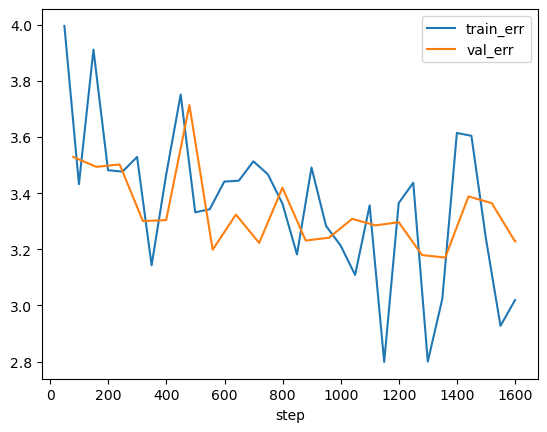

In [34]:
show_metrics('MLP')